In [ ]:
from pathlib import Path
import glob
import re

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_laplace, gaussian_filter
from skimage.feature import peak_local_max

from msr_reader import OBFFile
from msr_reader.xml_metadata import imspector_xml_to_dict
from autosted.utils.parameter_constants import PIXEL_SIZE_PARAMETERS
from autosted.utils.dict_utils import get_parameter_value_array_from_dict
from calmutils.localization.util import full_width_at_quantile_to_sigma


def load_data(file_path, stack_idx=0):

    # load image data and metadata
    with OBFFile(file_path) as reader:
        img = reader.read_stack(stack_idx).squeeze()
        meta = reader.get_imspector_xml_metadata(stack_idx)

    # get pixelsize from measurement metadata
    meas_meta = imspector_xml_to_dict(meta)['doc']
    pixel_size = get_parameter_value_array_from_dict(meas_meta, PIXEL_SIZE_PARAMETERS)

    return img, pixel_size


def detect_spots(img, pixel_size, expected_size=np.array([6e-7, 8e-8, 8e-8]), threshold=2.0):

    # to sigma for LoG
    expected_size_pixels = expected_size / pixel_size
    sigma = full_width_at_quantile_to_sigma(expected_size_pixels)

    # LoG filter and detect maxima above threshold
    log_img = gaussian_laplace(img.astype(float), sigma)
    peaks = peak_local_max(-log_img, threshold_abs=threshold)

    # get intensity at peak coords in slightly blurred image to mitigate noise
    intensities = gaussian_filter(img.astype(float), 0.5)[*peaks.T]

    df = dict(zip("zyx", peaks.T)) # pixel coords
    df |= dict(zip(['z_unit', 'y_unit', 'x_unit'], (peaks * pixel_size[np.newaxis, :]).T)) # unit coords
    df |= {'intensity': intensities}

    # dict to table and extra info: pixel size
    df = pd.DataFrame(df)
    df[[f'pixel_size_{d}' for d in 'zyx']] = pixel_size

    return df


## Bleaching Analysis

### 1. load data and detect spots -> save results as table

In [ ]:
# pattern of files to load, may include wildcards (*)
file_pattern = '/Volumes/hoerl/test_nup_640_notile/f06f7ef0_overview_0_cell_*_border_tile_0.msr'

# which acquisition type for details ('selective' or 'full')
acquisition_type = 'full'

out_file = '20251127_nup_intensities_full.csv'

dfs = []

for file in glob.glob(file_pattern):

    print(f'processing {file}...')

    # load data and run spot detection
    img, pixel_size = load_data(file, stack_idx=0)
    df = detect_spots(img, pixel_size)

    # add file stem and acquisition type to table
    df['file'] = Path(file).stem
    df['acquisition_type'] = acquisition_type

    # detail index: last _number in file name
    df['detail_idx'] = df['file'].apply(lambda s: int(s.split('_')[-1]))

    # cell id: drop last '_level_idx' from filename
    df['cell_id'] = df['file'].apply(lambda s: ''.join(re.split('(_.*?_\\d+)', s)[:-2]))

    if acquisition_type == 'selective':

        # 6 poles: 0,1 are top, bottom in z, others minmax in x or y -> middle
        idx_map = {0: 'top', 1: 'bottom', 2: 'middle', 3: 'middle', 4: 'middle', 5: 'middle'}
        df['z_class'] = df['detail_idx'].map(idx_map)

    elif acquisition_type == 'full':

        # selections for top 2um, bottom 2um and middle 2um
        top_selection = (df['z_unit'] - df['z_unit'].min()).abs() < 2e-6
        bottom_selection = (df['z_unit'] - df['z_unit'].max()).abs() < 2e-6
        middle_selection = (df['z_unit'] - (df['z_unit'].min() + df['z_unit'].max()) / 2).abs() < 1e-6

        df['z_class'] = pd.NA
        df.loc[top_selection, 'z_class'] = 'top'
        df.loc[middle_selection, 'z_class'] = 'middle'
        df.loc[bottom_selection, 'z_class'] = 'bottom'

    else:
        raise ValueError('Only "full" or "selective" supported as acquisition type.')

    dfs.append(df)

df = pd.concat(dfs).reset_index(drop=True)

dfs = []
for _, dfi in df.groupby('cell_id', sort=False):

    # get median intensity in top of cell
    top_median_intensity = dfi[dfi['z_class'] == 'top']['intensity'].median()
    dfi['intensity_relative'] = dfi['intensity'] / top_median_intensity

    dfs.append(dfi)

df = pd.concat(dfs)

df.to_csv(out_file, index=None)

### 2. Plots and stats

In [ ]:
### 1. all spots individually

import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

df_full = pd.read_csv('20251127_nup_intensities_full.csv')
df_poles = pd.read_csv('20251127_nup_intensities_selective.csv')

# combine and drop spots from full that are not in top, middle or bottom 2um
df_combined = pd.concat([df_full, df_poles])
df_combined = df_combined[~df_combined['z_class'].isna()]

# sns.barplot(df_combined, y='intensity_relative', x='z_class', hue='acquisition_type', estimator='median', errorbar='ci')
sns.boxplot(df_combined, y='intensity_relative', x='z_class', hue='acquisition_type', fliersize=4)
plt.ylim(0, 3)

for z, dfi in df_combined.groupby('z_class'):
    arr1 = dfi[dfi['acquisition_type'] == 'full']['intensity_relative']
    arr2 = dfi[dfi['acquisition_type'] == 'selective']['intensity_relative']
    print(z, mannwhitneyu(arr1, arr2))

bottom MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(6.208518738318076e-07))
middle MannwhitneyuResult(statistic=np.float64(11.0), pvalue=np.float64(3.3818083937386985e-06))
top MannwhitneyuResult(statistic=np.float64(180.0), pvalue=np.float64(0.4086785106184627))


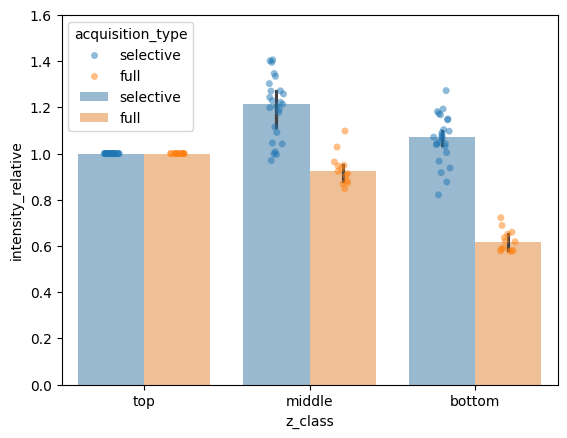

In [78]:
### 2. per cell

# get median spot intensity per cell & z_class
df_percell = df_combined.groupby(['cell_id', 'z_class', 'acquisition_type'])['intensity_relative'].median()
df_percell = df_percell.reset_index()

# plot just the medians per cell

sns.stripplot(df_percell, y='intensity_relative', x='z_class', hue='acquisition_type', order=['top', 'middle', 'bottom'], dodge=True, alpha=0.5)
sns.barplot(df_percell, y='intensity_relative', x='z_class', hue='acquisition_type', estimator='median', order=['top', 'middle', 'bottom'], alpha=0.5)
plt.ylim(0,1.6)

for z, dfi in df_percell.groupby('z_class'):
    arr1 = dfi[dfi['acquisition_type'] == 'full']['intensity_relative']
    arr2 = dfi[dfi['acquisition_type'] == 'selective']['intensity_relative']
    print(z, mannwhitneyu(arr1, arr2))

# with plt.rc_context({'svg.fonttype' :'none'}):
#     plt.savefig('intensity_fig.svg')

In [4]:
# copypase raw pvalues bottom, middle
pvals = [6.208518738318076e-07, 3.3818083937386985e-06]

# multiple testing corrections
_, pvals_corr, _, _ = multipletests(pvals)
pvals_corr

array([1.24170336e-06, 3.38180839e-06])

## Timing analysis

### 1. extract timing info from H5 dataset and save as table

In [ ]:
import h5py as h5
import datetime
from collections import defaultdict

h5file = '/Volumes/hoerl/autoSTED_Test_Data/20251126_nup_640/test_nup_640_notile/f06f7ef0.h5'
# h5file = '/Volumes/hoerl/autoSTED_Test_Data/20251126_nup_640/test_nup_640_poles/08800653.h5'


res = defaultdict(list)

with h5.File(h5file) as fd:

    for k in fd['experiment'].keys():
        indices = re.findall('_?(.*?)_(\\d+)', k)
        if len(indices) == 3:

            data = fd[f'experiment/{k}/0']

            res['ov_id'].append(int(indices[0][1]))
            res['cell_id'].append(int(indices[1][1]))
            res['detail_id'].append(int(indices[2][1]))

            starttime = datetime.datetime.fromtimestamp(data.attrs['run_start_time'])
            endtime = datetime.datetime.fromtimestamp(data.attrs['run_end_time'])

            res['starttime'].append(starttime)
            res['endtime'].append(endtime)

df = pd.DataFrame(res)
df['file'] = Path(h5file).stem
df['duration'] = df['endtime'] - df['starttime']

# df.to_csv('20251127_nup_timing_full.csv', index=None)

### 2. Plot per-cell acquisition time

(Timedelta('0 days 00:07:04'), Timedelta('0 days 00:00:54'), 7.851851851851852)

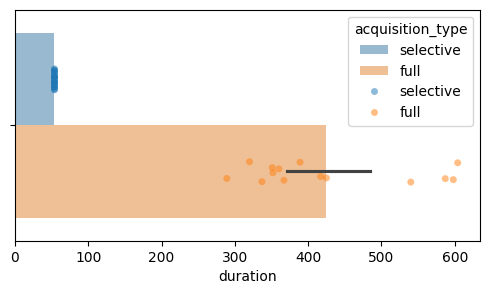

In [ ]:
time_df_full = pd.read_csv('20251127_nup_timing_full.csv')
time_df_full['acquisition_type'] = 'full'

time_df_selective = pd.read_csv('20251127_nup_timing_selective.csv')
time_df_selective['acquisition_type'] = 'selective'

time_df = pd.concat([time_df_full, time_df_selective])

# convert back to timedelta (in sec)
time_df['duration'] = pd.to_timedelta(time_df['duration']).astype('timedelta64[s]')

# sum acquisition times per cell
time_df_percell = time_df.groupby(['acquisition_type', 'ov_id', 'cell_id'])['duration'].sum().reset_index()

# plot barplot with individual cells overlay
fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(time_df_percell, ax=ax, x='duration', hue='acquisition_type', estimator='mean', alpha=0.5, hue_order=['selective', 'full'])
sns.stripplot(time_df_percell, ax=ax, x='duration', hue='acquisition_type', dodge=True, alpha=0.5, hue_order=['selective', 'full'])

# with plt.rc_context({'svg.fonttype' :'none'}):
#     fig.savefig('nup_timing_fig.svg')

# show mean time per cell full, selective, fold change
meant_full, meant_selective = time_df_percell.groupby('acquisition_type')['duration'].mean()
meant_full, meant_selective, meant_full / meant_selective